# Sentiment Classification of Apple and Google Tweets Using NLP
By DS-PT II Group 6

## Introduction
The purpose of this project is to build a model that can rate the sentiment of a tweet based on its content. The data is from https://data.world/crowdflower/brands-and-product-emotions. It contains over 9000 tweets about Apple and Google products rated by humans as either postive, negative, or neutral.

This notebook contains



## Data Cleaning

### Importing libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize




from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,accuracy_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")



### Load the dataset

In [2]:
df = pd.read_csv('tweet_data.csv', encoding= 'latin-1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
df.shape

(9093, 3)

From the above, we can see that the data is organized into 9093 rows and 3 columns: 
* tweet_text
* emotion_in_tweet_is_directed_at
* is_there_an_emotion_directed_at_a_brand_or_product

These column names are quite lengthy. Let's simplify them

In [4]:
# Change column names to be more user-friendly
df = df.rename(columns = {'tweet_text': 'Tweet', 
                         'emotion_in_tweet_is_directed_at': 'Device', 
                         'is_there_an_emotion_directed_at_a_brand_or_product': 'Emotion'})

# Confirm the changes
df.head()
                        

,Tweet,Device,Emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
# Check for missing values 
print(df.isnull().sum())
# Check for duplicates
print(df.duplicated().sum())


Tweet         1
Device     5802
Emotion       0
dtype: int64
22


From the above, we see that there is 1 missing value in the 'Tweet' column, 5802 missing values in the 'Device' column and none in the 'Emotion' column. There are 22 duplicates.

We will proceed to drop the duplicates column and fill 'unknown' for the missing values in the device column. For the 1 missing value in the 'Tweet' column we will delete the entire row.

In [6]:
# Drop duplicates
df = df.drop_duplicates()
# Fill missing values in 'Device' column with 'unknown'
df['Device'] = df['Device'].fillna('unknown')
# Drop rows with missing values in 'Tweet' column
df = df.dropna(subset=['Tweet'])


In [7]:
# Confirm the changes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9070 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Tweet    9070 non-null   object
 1   Device   9070 non-null   object
 2   Emotion  9070 non-null   object
dtypes: object(3)
memory usage: 283.4+ KB


Let's take a look at the value counts within the emotion column to understand the relationship between positive, negative and neutral tweets.

In [8]:
df['Emotion'].value_counts()

No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: Emotion, dtype: int64

As you can see in the cell above, there are 4 different types of sentiments expressed about the devices: 'No emotion toward brand or product', 'Positive emotion', 'Negative emotion' and 'I can't tell'.

These are too lengthy, so we will rename them into something more user-friendly.

Also, the first and last column are quite similar, so we will proceed to merge them into one.


In [9]:
# Merge 'No emotion toward brand or product' and 'I can't tell' into 'Neutral'
def clean_emotions(df, column): #Building function to change emotions
    emotion_list = [] #Making list for new names of emotions
    for i in df[column]:
        if i == "No emotion toward brand or product": #Renaming no emotions
            emotion_list.append('Neutral') #Renaming as Neutral
        elif i == "I can't tell": #Renaming I can't tell
            emotion_list.append('Neutral') #Renaming as Neutral
        elif i == "Positive emotion": #Renaming positive emotion
            emotion_list.append('Positive') #Renaming as Positive
        elif i == "Negative emotion": #Renaming negative emotion
            emotion_list.append('Negative') #Renaming as Negative
    df['Emotion'] = emotion_list #Setting column to new names
    return df

df = clean_emotions(df, 'Emotion') #Set df to clean emotions function
df['Emotion'].value_counts() #Checking value counts to see if they were changed

Neutral     5531
Positive    2970
Negative     569
Name: Emotion, dtype: int64

Let's take a look at the value counts within the device column to understand the column distribution

In [10]:
# 
df['Device'].value_counts()

unknown                            5788
iPad                                945
Apple                               659
iPad or iPhone App                  469
Google                              428
iPhone                              296
Other Google product or service     293
Android App                          80
Android                              77
Other Apple product or service       35
Name: Device, dtype: int64

The distribution across products is quite skewed. More than half of the tweets don’t reference a specific product. To address this, we plan to introduce a new column called “Brand”, which will indicate whether the tweet relates to Apple or Google, using the information already available in the “Product” column. Since the dataset focuses on these two companies, having this brand-level detail may prove useful later, so it makes sense to set it up now.

The process will be as follows: first, we’ll review all entries in the “Device” column. Next, we’ll write a function that goes through this column and assigns the appropriate brand to the new column. If the product is not specified, the function will then check the tweet text itself for product-related keywords. If no keywords are found, the brand will remain “Unknown.” If terms for both Apple and Google are detected, the entry will be labeled “Both.” The goal is to create more balanced classes for this new feature.

In [11]:
device_mapping = {
    "iPad": "Apple",
    "Apple": "Apple",
    "iPad or iPhone App": "Apple",
    "iPhone": "Apple",
    "Other Apple product or service": "Apple",
    
    "Google": "Google",
    "Other Google product or service": "Google",
    "Android": "Google",
    "Android App": "Google",
    
    "Unknown": "Unknown",
    
}

# Map first from the Device column
df["Brand"] = df["Device"].map(device_mapping).fillna("Unknown")

# Handle "Both" case if tweet mentions both Apple and Google/Android
df["Brand"] = df.apply(
    lambda row: "Both" if (
        ("apple" in str(row["Tweet"]).lower() or "ip" in str(row["Tweet"]).lower()) and
        ("google" in str(row["Tweet"]).lower() or "android" in str(row["Tweet"]).lower())
    ) else row["Brand"],
    axis=1
)

# Check final distribution
brand_distribution = df["Brand"].value_counts()
brand_distribution

Unknown    5575
Apple      2359
Google      836
Both        300
Name: Brand, dtype: int64

We also want to try and understand a few characteristics of the tweets. To acheive this, we will add 3 more columns to our dataset that will be useful for the exploratory data analysis (EDA) process: 
1. Tweet character count.
2. Hashtags.
3. Hashtag count.

In [12]:
def tweet_character_count(text_of_tweet): #Function to count characters in tweet
    return len(text_of_tweet.strip()) #Returns length of tweet

df['Tweet Character Count'] = df.apply(lambda row: tweet_character_count(row['Tweet']), axis = 1) #Making new column

df['Hashtag'] = df['Tweet'].apply(lambda x: re.findall(r'\B#\w*[a-zA-Z]+\w*', x)) #Making hashtag column

df['Hashtag Count'] = df['Hashtag'].str.len() #Creating column with number of Hashtags used

# df['Clean'] = df['Tweet'] #New column for cleaned tweets

df.head() #Checking to see if columns were created accurately

,Tweet,Device,Emotion,Brand,Tweet Character Count,Hashtag,Hashtag Count
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,Apple,127,"[#RISE_Austin, #SXSW]",2
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple,139,[#SXSW],1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple,79,"[#iPad, #SXSW]",2
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,Apple,82,[#sxsw],1
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Google,131,[#SXSW],1


### Text Pre-processing

Before we begin tokenisation, we need to omit the stopwords that exist within the tweets. This is because they are bulky datapoints that will only slow down our model. However, a realisation that words that convey negative sentiment is quickly apparent. We, therefore, need to take a look at the stopwords library to determine whether it is suitable.

It is clear that omitting all stopwords will get rid of negative sentiments within tweets. So, to address this issue, we will run code that keeps these stop words intact within the tweets.

In [13]:
# Tokenizer and lemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

tokenizer = RegexpTokenizer(r'\b\w{3,}\b')
lemmatizer = WordNetLemmatizer()

# Load NLTK stopwords
stop_words = set(stopwords.words("english"))

# Define negation words you want to KEEP
negation_words = {"no", "not", "nor", "never", "none", "nobody", 
                  "nothing", "neither", "cannot", "n't"}

# Words you want to REMOVE (custom)
extra_stopwords = {"link", "rt", "sxsw", "amp"}

# Create final custom stopwords
custom_stopwords = (stop_words - negation_words) | extra_stopwords

print("Default stopwords count:", len(stop_words))
print("Custom stopwords count:", len(custom_stopwords))
print("Negations preserved:", negation_words)

Default stopwords count: 198
Custom stopwords count: 199
Negations preserved: {'none', 'not', 'nobody', 'cannot', 'neither', 'nothing', 'never', 'no', "n't", 'nor'}


In order to turn a tweet into text data that can be modelled on NLP, we need to do the following:
1. Make everything lowercase
2. Remove all URLs or URL placeholder values
3. Remove all mentions and hashtags
4. Remove all characters that aren't letters
5. Remove all punctuation
6. Remove all extra spaces

In [14]:
#Preprocess the text

def clean_text(text):
    text = text.lower()
    # Remove mentions, hashtags, and URLs
    text = re.sub(r'@\w+|#\w+|http\S+|www\S+|https\S+', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = tokenizer.tokenize(text)
    
    # Remove stopwords (custom list)
    cleaned_text = [word for word in tokens if word not in custom_stopwords]
    
    # Lemmatize
    cleaned_text = [lemmatizer.lemmatize(word) for word in cleaned_text]  
    return cleaned_text

In [15]:
# Apply preprocessing to the correct column
df["Clean_Tweet"] = df["Tweet"].apply(clean_text)

# Preview cleaned text
print(df[["Tweet", "Clean_Tweet"]].head())

                                               Tweet  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   

                                         Clean_Tweet  
0  [iphone, hr, tweeting, dead, need, upgrade, pl...  
1  [know, awesome, ipadiphone, app, youll, likely...  
2                            [not, wait, also, sale]  
3  [hope, year, festival, isnt, crashy, year, iph...  
4  [great, stuff, fri, marissa, mayer, google, ti...  


Now let us visualise our output following the pre-processing

In [16]:
df.head()

,Tweet,Device,Emotion,Brand,Tweet Character Count,Hashtag,Hashtag Count,Clean_Tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,Apple,127,"[#RISE_Austin, #SXSW]",2,"[iphone, hr, tweeting, dead, need, upgrade, pl..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple,139,[#SXSW],1,"[know, awesome, ipadiphone, app, youll, likely..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple,79,"[#iPad, #SXSW]",2,"[not, wait, also, sale]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,Apple,82,[#sxsw],1,"[hope, year, festival, isnt, crashy, year, iph..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Google,131,[#SXSW],1,"[great, stuff, fri, marissa, mayer, google, ti..."


From this visualisation, we have ended up with a cleaned dataset that has organised our data into 8 columns. We have completed preprocessing the data.

### Exploratory Data Analysis

Having tokenised our tweets, we need to gain a clear understanding of the dataset. We will generate visuals to help with that. To help with that, let us visualise the head of the data to understand what categories we are dealing with.

In [17]:
df.head()

,Tweet,Device,Emotion,Brand,Tweet Character Count,Hashtag,Hashtag Count,Clean_Tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,Apple,127,"[#RISE_Austin, #SXSW]",2,"[iphone, hr, tweeting, dead, need, upgrade, pl..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple,139,[#SXSW],1,"[know, awesome, ipadiphone, app, youll, likely..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple,79,"[#iPad, #SXSW]",2,"[not, wait, also, sale]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,Apple,82,[#sxsw],1,"[hope, year, festival, isnt, crashy, year, iph..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Google,131,[#SXSW],1,"[great, stuff, fri, marissa, mayer, google, ti..."


The first visual we will generate is the distribution of emotions.

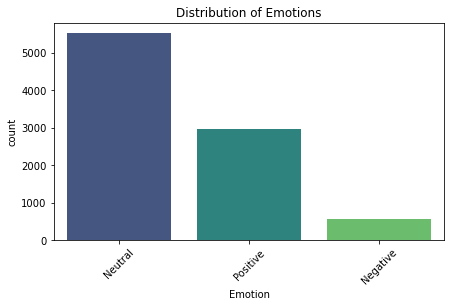

In [18]:
plt.figure(figsize=(7,4))
sns.countplot(x="Emotion", data=df, order=df["Emotion"].value_counts().index, palette="viridis")
plt.title("Distribution of Emotions")
plt.xticks(rotation=45)
plt.show()

Next, we will visualise the distribution of brands and emotions therein.

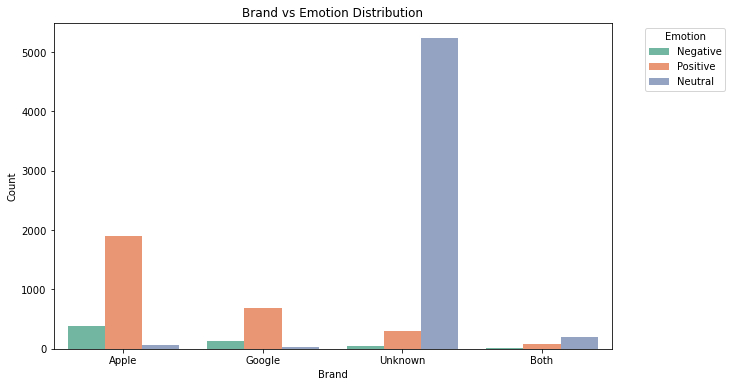

In [19]:
plt.figure(figsize=(10,6))
sns.countplot(x="Brand", hue="Emotion", data=df, palette="Set2")
plt.title("Brand vs Emotion Distribution")
plt.xlabel("Brand")
plt.ylabel("Count")
plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

Next, we will take a look at tweet length

In [20]:
df["word_count"] = df["Clean_Tweet"].apply(lambda x:len(str(x).split()))
df["char_count"] = df["Clean_Tweet"].apply(lambda x:len(str(x)))

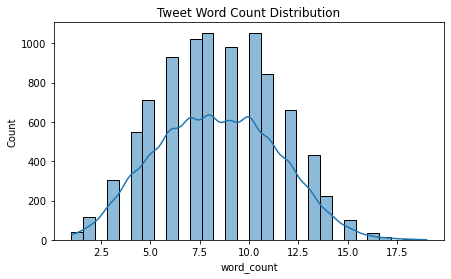

In [21]:
plt.figure(figsize=(7,4))
sns.histplot(df["word_count"], bins=30, kde=True)
plt.title("Tweet Word Count Distribution")
plt.show()

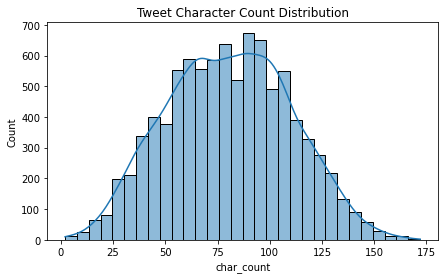

In [22]:
plt.figure(figsize=(7,4))
sns.histplot(df["char_count"], bins=30, kde=True)
plt.title("Tweet Character Count Distribution")
plt.show()

Next, we will generate visuals based on the text we are using. 

In [23]:
from collections import Counter

def get_top_n_words(corpus, n=20):
    # If each entry is a list of tokens
    if isinstance(corpus.iloc[0], list):
        words = [word for tokens in corpus for word in tokens]  # flatten list of lists
    else:
        words = " ".join(corpus).split()  # if already strings
    
    common_words = Counter(words).most_common(n)
    return pd.DataFrame(common_words, columns=["Word", "Frequency"])

# Example usage:
print("\nTop words overall:\n", get_top_n_words(df["Clean_Tweet"], 20))


Top words overall:
        Word  Frequency
0      ipad       2308
1    google       2194
2     apple       1835
3     store       1501
4    iphone       1249
5       new       1081
6    austin        848
7       app        788
8    launch        674
9    social        616
10    popup        597
11    today        566
12   circle        536
13      not        520
14  network        462
15      get        454
16     line        438
17  android        436
18      via        435
19    party        377


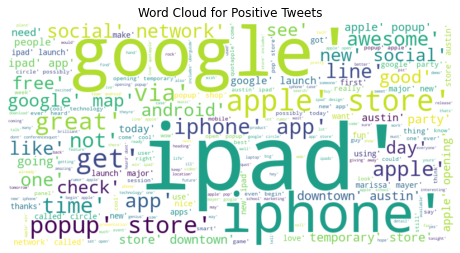

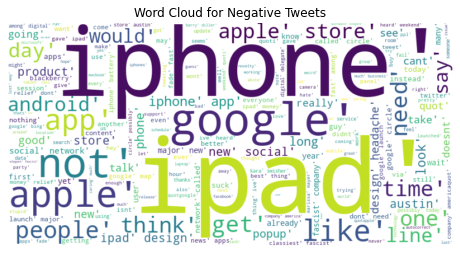

In [24]:
# Wordcloud for positive vs negative tweets

from wordcloud import WordCloud
for emotion in ["Positive", "Negative"]:
    text = " ".join(df[df["Emotion"]==emotion]["Clean_Tweet"].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(8,5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {emotion} Tweets")
plt.show()

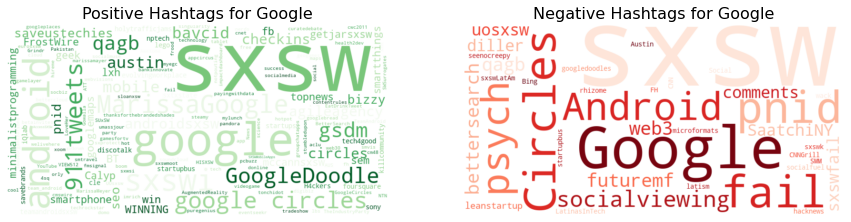

In [25]:
# Filter Google tweets only
google_df = df[df["Brand"].str.lower() == "google"]

# Function to flatten hashtags
def flatten_hashtags(series):
    hashtags = []
    for item in series.dropna():
        if isinstance(item, list):  # if hashtags are stored as lists
            hashtags.extend(item)
        else:  # if single string
            hashtags.append(item)
    return " ".join(hashtags)

# Positive hashtags
positive_hashtags = flatten_hashtags(
    google_df[google_df["Emotion"].str.lower() == "positive"]["Hashtag"]
)

# Negative hashtags
negative_hashtags = flatten_hashtags(
    google_df[google_df["Emotion"].str.lower() == "negative"]["Hashtag"]
)

# Generate word clouds
plt.figure(figsize=(15, 7))

# Positive
plt.subplot(1, 2, 1)
wc_pos = WordCloud(width=800, height=400, background_color="white", colormap="Greens").generate(positive_hashtags)
plt.imshow(wc_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Hashtags for Google", fontsize=16)

# Negative
plt.subplot(1, 2, 2)
wc_neg = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate(negative_hashtags)
plt.imshow(wc_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Hashtags for Google", fontsize=16)

plt.show()

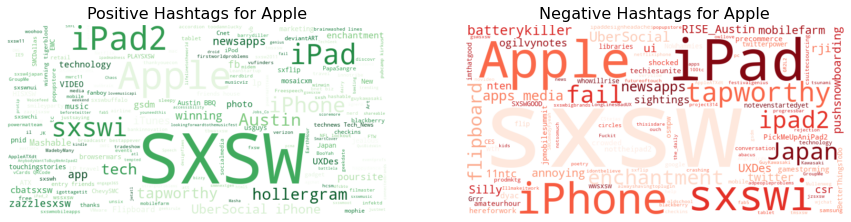

In [26]:
# Filter Apple tweets only
apple_df = df[df["Brand"].str.lower() == "apple"]

# Function to flatten hashtags
def flatten_hashtags(series):
    hashtags = []
    for item in series.dropna():
        if isinstance(item, list):  # if hashtags are stored as lists
            hashtags.extend(item)
        else:  # if single string
            hashtags.append(item)
    return " ".join(hashtags)

# Positive hashtags
positive_hashtags = flatten_hashtags(
    apple_df[apple_df["Emotion"].str.lower() == "positive"]["Hashtag"]
)

# Negative hashtags
negative_hashtags = flatten_hashtags(
    apple_df[apple_df["Emotion"].str.lower() == "negative"]["Hashtag"]
)

# Generate word clouds
plt.figure(figsize=(15, 7))

# Positive
plt.subplot(1, 2, 1)
wc_pos = WordCloud(width=800, height=400, background_color="white", colormap="Greens").generate(positive_hashtags)
plt.imshow(wc_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Hashtags for Apple", fontsize=16)

# Negative
plt.subplot(1, 2, 2)
wc_neg = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate(negative_hashtags)
plt.imshow(wc_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Hashtags for Apple", fontsize=16)

plt.show()

In [27]:
# Sentiment Analysis for Positive & Negative Apple Tweets 
from wordcloud import STOPWORDS
from nltk.sentiment import SentimentIntensityAnalyzer


# Download VADER lexicon once
# nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()



In [28]:
# Ensure Clean_Tweet is a string (join tokens if it's a list)
df["Clean_Tweet"] = df["Clean_Tweet"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))

# Filter Apple tweets only
df_apple = df[df["Brand"].str.lower() == "apple"]

# Separate sentiments
df_pos = df_apple[df_apple["Emotion"].str.lower() == "positive"]
df_neg = df_apple[df_apple["Emotion"].str.lower() == "negative"]

# Extra stopwords (remove brand terms so they don’t dominate)
extra_stops = {
    "apple","iphone","ipad","mac","macbook","imac","ios","watch","applewatch",
    "app","store","airpods","vision","pro","rt","https","http","co","amp"
}
stops = STOPWORDS.union(extra_stops)

# Build text corpora
text_pos = " ".join(df_pos["Clean_Tweet"].dropna())
text_neg = " ".join(df_neg["Clean_Tweet"].dropna())

# Generate wordclouds
wc_pos = WordCloud(width=800, height=600, background_color="white",
                   stopwords=stops, max_words=200).generate(text_pos)

wc_neg = WordCloud(width=800, height=600, background_color="black",
                   stopwords=stops, colormap="Reds", max_words=200).generate(text_neg)



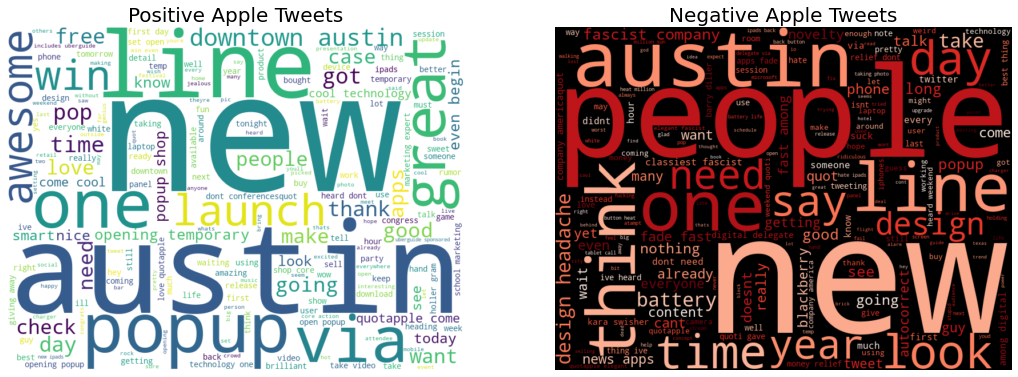

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(18, 9))

axs[0].imshow(wc_pos, interpolation="bilinear")
axs[0].set_title("Positive Apple Tweets", fontsize=20)
axs[0].axis("off")

axs[1].imshow(wc_neg, interpolation="bilinear")
axs[1].set_title("Negative Apple Tweets", fontsize=20)
axs[1].axis("off")

plt.show()


In [30]:
# Filter Google tweets only
df_google = df[df["Brand"].str.lower() == "google"]

# Separate sentiments
df_pos = df_google[df_google["Emotion"].str.lower() == "positive"]
df_neg = df_google[df_google["Emotion"].str.lower() == "negative"]

# Extra stopwords (remove brand terms so they don’t dominate)
extra_stops = {
    "google","android","pixel","chrome","chromebook","gmail","youtube","maps","play",
    "search","assistant","nest","cloud","rt","https","http","co","amp"
}
stops = STOPWORDS.union(extra_stops)

# Build text corpora
text_pos = " ".join(df_pos["Clean_Tweet"].dropna())
text_neg = " ".join(df_neg["Clean_Tweet"].dropna())

# Generate wordclouds
wc_pos = WordCloud(width=800, height=600, background_color="white",
                   stopwords=stops, max_words=200).generate(text_pos)

wc_neg = WordCloud(width=800, height=600, background_color="black",
                   stopwords=stops, colormap="Reds", max_words=200).generate(text_neg)



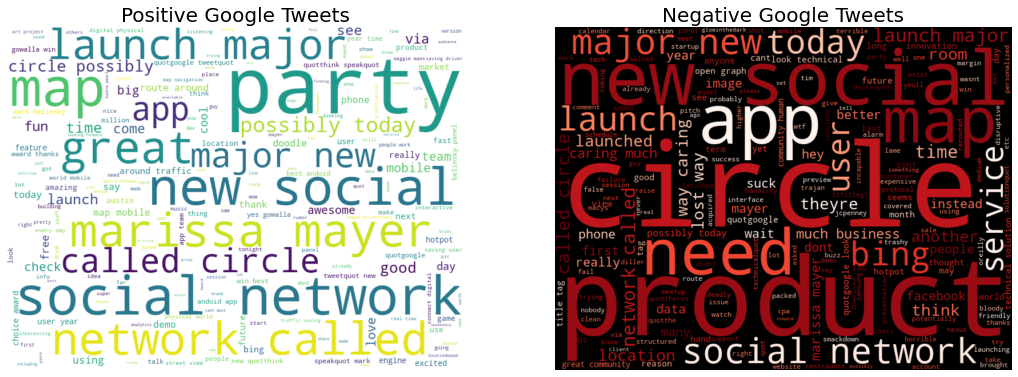

In [31]:
# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(18, 9))

axs[0].imshow(wc_pos, interpolation="bilinear")
axs[0].set_title("Positive Google Tweets", fontsize=20)
axs[0].axis("off")

axs[1].imshow(wc_neg, interpolation="bilinear")
axs[1].set_title("Negative Google Tweets", fontsize=20)
axs[1].axis("off")

plt.show()


This marks the end of our Exploratory Data Analysis (EDA). We will now progress to the next stage.

### Modelling

In [32]:
df.head()

,Tweet,Device,Emotion,Brand,Tweet Character Count,Hashtag,Hashtag Count,Clean_Tweet,word_count,char_count
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,Apple,127,"[#RISE_Austin, #SXSW]",2,iphone hr tweeting dead need upgrade plugin st...,8,76
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple,139,[#SXSW],1,know awesome ipadiphone app youll likely appre...,12,119
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple,79,"[#iPad, #SXSW]",2,not wait also sale,4,31
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,Apple,82,[#sxsw],1,hope year festival isnt crashy year iphone app,8,71
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Google,131,[#SXSW],1,great stuff fri marissa mayer google tim oreil...,13,135


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9070 entries, 0 to 9092
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Tweet                  9070 non-null   object
 1   Device                 9070 non-null   object
 2   Emotion                9070 non-null   object
 3   Brand                  9070 non-null   object
 4   Tweet Character Count  9070 non-null   int64 
 5   Hashtag                9070 non-null   object
 6   Hashtag Count          9070 non-null   int64 
 7   Clean_Tweet            9070 non-null   object
 8   word_count             9070 non-null   int64 
 9   char_count             9070 non-null   int64 
dtypes: int64(4), object(6)
memory usage: 1.1+ MB


We will build a binary model using positive and negative tweets to function as our baseline which will be simple and allow us to iterate also to make sure that the pipeline is working before scaling up to a multiclass or more sophisticated approach.
we will conduct a train test split (test size=0.2) then build two pipelines :CountVectorizer and TFIDF Vectorizer and compare the results.


In [34]:
# keep only positive and negative tweets
binary_df = df[df["Emotion"].isin(["Positive", "Negative"])].copy()

# train test split
X = binary_df["Clean_Tweet"].astype(str)
y = binary_df["Emotion"].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")



Training samples: 2831, Testing samples: 708


In [35]:
# using CountVectorizer instead of TfidfVectorizer
base_pipeline = Pipeline([
    ('count', CountVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

base_pipeline.fit(X_train, y_train)

y_pred = base_pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

Accuracy: 0.865819209039548
              precision    recall  f1-score   support

    Negative       0.68      0.32      0.43       114
    Positive       0.88      0.97      0.92       594

    accuracy                           0.87       708
   macro avg       0.78      0.64      0.68       708
weighted avg       0.85      0.87      0.84       708



In [36]:
# using CountVectorizer instead of TfidfVectorizer
base_pipeline_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

base_pipeline_tfidf.fit(X_train, y_train)

y_pred = base_pipeline_tfidf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

Accuracy: 0.8502824858757062
              precision    recall  f1-score   support

    Negative       0.79      0.10      0.17       114
    Positive       0.85      0.99      0.92       594

    accuracy                           0.85       708
   macro avg       0.82      0.55      0.54       708
weighted avg       0.84      0.85      0.80       708



From our train-test split we have 2831 Training samples and 708 test smples
Count Vectorizer achieved an accuracy of 86.58%, meaning it performed slightly better at predicting the correct labels on the test set.
TF-IDF Vectorizer had a slightly lower accuracy of 85.03%.
This suggests that, simple word frequency (Count Vectorizer) captured the relevant information slightly better than term frequency–inverse document frequency (TF-IDF). However, the difference is relatively small.


The following code prepares our dataset for an emotion classification task by ensuring the data types are appropriate and encoding the labels.

In [ ]:
## Features = tweets, Labels = sentiment
X = df["Clean_Tweet"].astype(str)   # ensure text format
y = df["Emotion"].astype(str)     # labels

# Initialize the LabelEncoder
label_encoder = LabelEncoder()
#Fit the encoder and transform the labels into numeric form
y_encoded = label_encoder.fit_transform(y)
# Print the class labels found in the data
print("Classes:", label_encoder.classes_)

Classes: ['Negative' 'Neutral' 'Positive']
